In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import langevin
import langevin_cached_model as lcm
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.optimize import minimize_scalar

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [2]:
# function to calculate A and B from the dataset
def OUanalytic1(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/2/A**2
    Btmp = (N-1)*(1+B**2)/(1-B**2)**2
    tmp = (2+6*B**2)*(data1sq+dataNsq) + (4+12*B**2)*datasq - (12*B+4*B**3)*datacorr
    P2B = Btmp - tmp/A/2/(1-B**2)**3
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult1(data,deltat):
    A, dA, B ,dB = OUanalytic1(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [3]:
# function to calculate A and B from the dataset
def OUanalytic2(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult2(data,deltat):
    A, dA, B ,dB = OUanalytic2(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [7]:
A,D = 1.0,2.0
tau_real = D/A
delta_t_list=np.linspace(0.01,1,50)
#M=1000 # number of data sets
N=50000 # length of data set
#print(np.exp(-delta_t*D/A))

In [8]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

result_Bayes_array = None
for delta_t in delta_t_list:
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult1(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

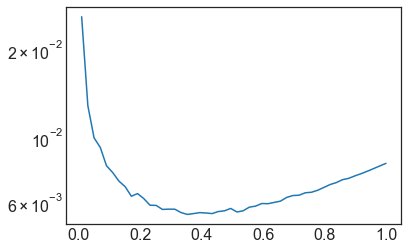

In [9]:
plt.semilogy(delta_t_list,result_Bayes_array.T[3])

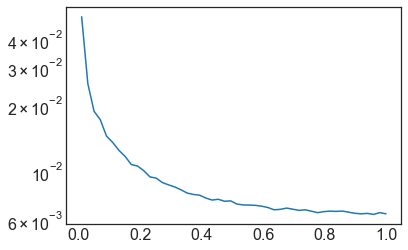

In [10]:
plt.semilogy(delta_t_list,result_Bayes_array.T[1])

In [28]:
A,D = 1.0,2.0
tau_real = D/A
delta_t_list=np.linspace(0.01,1,50)
#M=1000 # number of data sets
N=50000 # length of data set
#print(np.exp(-delta_t*D/A))
pick_delta = 7
print(delta_t_list[pick_delta])
data = langevin.time_series(A=A, D=D, delta_t=delta_t_list[pick_delta], N=N)

0.15142857142857144


In [12]:
# compile model for reuse
sm = lcm.OU_DA()
sm.samples=20000

In [13]:
trace = sm.run(x=data,
                d_bound=5,
                a_bound=5,
                delta_t=delta_t_list[pick_delta],
                N=50000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:40<00:00, 2013.37draws/s]
/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1fc4e4e0>,
      dtype=object)

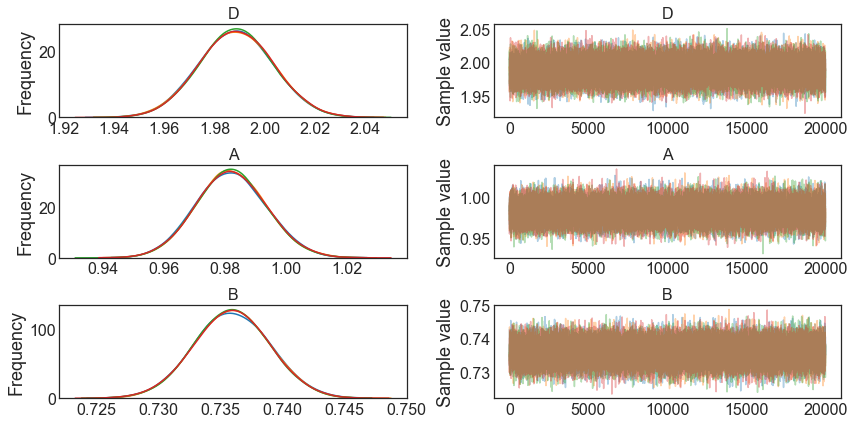

In [14]:
pm.traceplot(trace)

In [15]:
result_array = None
for delta_t in delta_t_list:
    print(delta_t)
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    trace = sm.run(x=data,
                d_bound=5,
                a_bound=5,
                delta_t=delta_t,
                N=50000)
    a_mean = trace['A'].mean()
    d_mean = trace['D'].mean()
    a_std = trace['A'].std()
    d_std = trace['D'].std()
    results = [a_mean,a_std,d_mean,d_std]
    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.01


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:41<00:00, 1981.95draws/s]
/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.030204081632653063


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:40<00:00, 2008.67draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.05040816326530612


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:39<00:00, 2075.65draws/s]
The acceptance probability does not match the target. It is 0.8811865530209128, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.07061224489795918


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 1895.15draws/s]
The acceptance probability does not match the target. It is 0.8930304368867549, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.09081632653061224


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:39<00:00, 2081.43draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.11102040816326529


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:41<00:00, 1983.89draws/s]
The acceptance probability does not match the target. It is 0.8812919512996175, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8901665459809859, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.13122448979591836


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:40<00:00, 2024.13draws/s]


0.15142857142857144


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:40<00:00, 2016.32draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.1716326530612245


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:40<00:00, 2004.54draws/s]
The acceptance probability does not match the target. It is 0.8794582772141188, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.19183673469387755


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:42<00:00, 1934.91draws/s]
The acceptance probability does not match the target. It is 0.8837121468570523, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8838689159688524, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.2120408163265306


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:39<00:00, 2080.74draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.23224489795918368


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:40<00:00, 2037.72draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.2524489795918367


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:42<00:00, 1913.68draws/s]
The acceptance probability does not match the target. It is 0.8817290399067845, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.2726530612244898


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:41<00:00, 1984.38draws/s]


0.29285714285714287


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:42<00:00, 1919.97draws/s]
The acceptance probability does not match the target. It is 0.8799617597669116, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.3130612244897959


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 1893.62draws/s]
The acceptance probability does not match the target. It is 0.8901229282819242, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8823204797835394, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.333265306122449


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:42<00:00, 1928.80draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.35346938775510206


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 1875.28draws/s]
The acceptance probability does not match the target. It is 0.8790517851686063, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.3736734693877551


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:42<00:00, 1913.65draws/s]
The acceptance probability does not match the target. It is 0.8800803709308626, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.39387755102040817


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1834.32draws/s]
The acceptance probability does not match the target. It is 0.888406456190628, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8856194242793264, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.4140816326530612


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 1863.77draws/s]
The acceptance probability does not match the target. It is 0.8867604047907117, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.4342857142857143


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:40<00:00, 2032.82draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.45448979591836736


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 520.11draws/s] 
The acceptance probability does not match the target. It is 0.8787302680597793, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.4746938775510204


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 1905.22draws/s]
The acceptance probability does not match the target. It is 0.8854476781255805, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.49489795918367346


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:42<00:00, 1912.19draws/s]
The acceptance probability does not match the target. It is 0.8825333131760891, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.5151020408163265


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:46<00:00, 1756.03draws/s]
The acceptance probability does not match the target. It is 0.891954399186093, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8838583877030143, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.5353061224489796


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:47<00:00, 1737.19draws/s]
The acceptance probability does not match the target. It is 0.8816591422282853, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.5555102040816327


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1810.52draws/s]
The acceptance probability does not match the target. It is 0.8804259922377382, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.5757142857142857


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:41<00:00, 1964.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.5959183673469388


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:41<00:00, 1952.83draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.6161224489795918


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 1863.69draws/s]
The acceptance probability does not match the target. It is 0.8868877963794802, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.6363265306122449


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 1877.58draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.656530612244898


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 1877.03draws/s]
The acceptance probability does not match the target. It is 0.8849358916731189, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.676734693877551


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1851.93draws/s]
The acceptance probability does not match the target. It is 0.8797982186237211, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8791801216110434, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.6969387755102041


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 1906.85draws/s]
The acceptance probability does not match the target. It is 0.8838856457197058, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.7171428571428571


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1813.29draws/s]
The acceptance probability does not match the target. It is 0.8909979066053125, but should be close to 0.8. Try to increase the number of tuning steps.


0.7373469387755102


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1798.06draws/s]
The acceptance probability does not match the target. It is 0.8902724438623497, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8808157623357508, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8919594295945404, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.7575510204081632


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:42<00:00, 1943.40draws/s]
The acceptance probability does not match the target. It is 0.879159192791066, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.7777551020408163


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:46<00:00, 1772.54draws/s]
The acceptance probability does not match the target. It is 0.8855904858947643, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.7979591836734694


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1838.85draws/s]
The acceptance probability does not match the target. It is 0.8805035989112862, but should be close to 0.8. Try to increase the number of tuning steps.


0.8181632653061224


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1805.11draws/s]
The acceptance probability does not match the target. It is 0.8855492235553032, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8872254037985172, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.8383673469387755


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1818.13draws/s]
The acceptance probability does not match the target. It is 0.8899768119611188, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8884141249672238, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.8585714285714285


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:46<00:00, 1745.29draws/s]
The acceptance probability does not match the target. It is 0.8848313549950856, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8861125374238555, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.8787755102040816


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:42<00:00, 1923.43draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.8989795918367347


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 1871.63draws/s]
The acceptance probability does not match the target. It is 0.879549623378959, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8804153572194838, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.9191836734693878


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1855.77draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.9393877551020408


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:48<00:00, 1693.93draws/s]
The acceptance probability does not match the target. It is 0.8842797109067358, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.9595918367346938


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:46<00:00, 1755.74draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.9797959183673469


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:51<00:00, 1590.06draws/s]
The acceptance probability does not match the target. It is 0.8960280808514692, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8794280408002171, but should be close to 0.8. Try to increase the number of tuning steps.


1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:52<00:00, 1552.28draws/s]
The acceptance probability does not match the target. It is 0.8838426037735831, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8882060855545225, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8814011758557087, but should be close to 0.8. Try to increase the number of tuning steps.


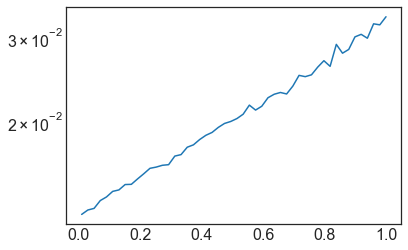

In [16]:
plt.semilogy(delta_t_list,result_array.T[3])

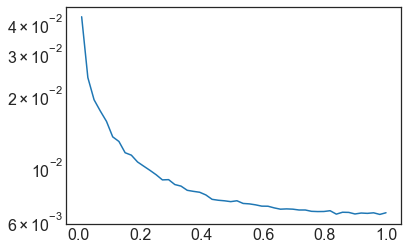

In [17]:
plt.semilogy(delta_t_list,result_array.T[1])

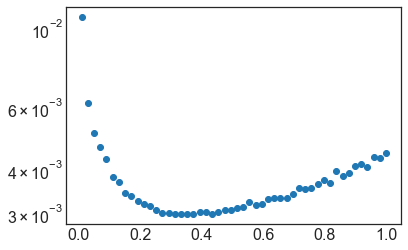

In [29]:
dtau = np.sqrt(result_array.T[1]**2/D**2+A**2/D**4*result_array.T[3]**2)
plt.semilogy(delta_t_list,dtau/tau_real,"o")

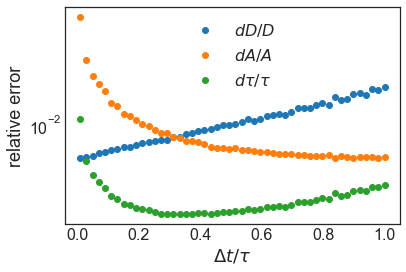

In [32]:
plt.semilogy(delta_t_list,result_array.T[3]/D,"o",label=r"$dD/D$")
plt.semilogy(delta_t_list,result_array.T[1]/A,"o",label=r'$dA/A$')
plt.semilogy(delta_t_list,dtau/tau_real,"o",label=r'$d\tau/\tau$')
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel("relative error")
plt.legend()

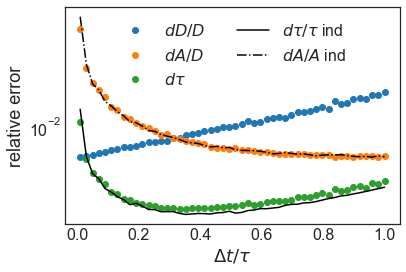

In [41]:
plt.semilogy(delta_t_list,result_array.T[3]/D,"o",label=r"$dD/D$")
plt.semilogy(delta_t_list,result_array.T[1]/A,"o",label=r'$dA/D$')
plt.semilogy(delta_t_list,dtau/tau_real,"o",label=r'$d\tau$')
plt.semilogy(delta_t_list,result_Bayes_array.T[3]/tau_real,color="k",label=r"$d\tau/\tau$ ind")
plt.semilogy(delta_t_list,result_Bayes_array.T[1]/A,"-.",color="k",label=r"$dA/A$ ind")
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel("relative error")
plt.legend(ncol=2)
plt.savefig("optimaldt_1_2.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")